本notebook收集与[《交通时空大数据分析、挖掘与可视化（Python版）》](https://book.douban.com/subject/36092545/)

# 出租车数据处理

下面我们介绍如何使用TransBigData包，调用其中的函数实现对出租车GPS数据的快速处理。  
首先我们引入TransBigData包，并读取数据:

In [19]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
#读取数据    
data = pd.read_csv('data/TaxiData-Sample.csv',header = None) 
data.columns = ['VehicleNum','time','lon','lat','OpenStatus','Speed']
data

,VehicleNum,time,lon,lat,OpenStatus,Speed
0,34745,20:27:43,113.806847,22.623249,1,27
1,34745,20:24:07,113.809898,22.627399,0,0
2,34745,20:24:27,113.809898,22.627399,0,0
3,34745,20:22:07,113.811348,22.628067,0,0
4,34745,20:10:06,113.819885,22.647800,0,54
...,...,...,...,...,...,...
544994,28265,21:35:13,114.321503,22.709499,0,18
544995,28265,09:08:02,114.322701,22.681700,0,0
544996,28265,09:14:31,114.336700,22.690100,0,0
544997,28265,21:19:12,114.352600,22.728399,0,0


<AxesSubplot:>

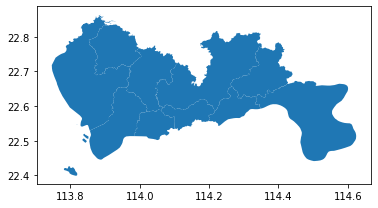

In [20]:
#读取区域信息
import geopandas as gpd
sz = gpd.read_file(r'data/sz/sz.shp')
sz.crs = None
sz.plot()

## 对数据进行预处理

TransBigData包也集成了数据预处理的常用方法。其中，tbd.clean_outofshape方法输入数据和研究范围区域信息，筛选剔除研究范围外的数据。而tbd.clean_taxi_status方法则可以剔除前面所提到的载客状态瞬间变化的记录。在使用预处理的方法时，需要传入相应的列，代码如下：

In [21]:
#数据预处理
#剔除研究范围外的数据
data = tbd.clean_outofshape(data, sz, col=['lon', 'lat'], accuracy=500)
#剔除出租车数据中载客状态瞬间变化的记录
data = tbd.clean_taxi_status(data, col=['VehicleNum', 'time', 'OpenStatus'])

## 栅格化

以栅格形式表达数据分布是最基本的表达方法。GPS数据经过栅格化后，每个数据点都含有对应的栅格信息，采用栅格表达数据的分布时，其表示的分布情况与真实情况接近。如果要使用TransBigData工具进行栅格首先需要确定栅格化的参数，参数可以帮助我们快速进行栅格化:


In [22]:
#栅格化
#定义研究范围
bounds = [113.75, 22.4, 114.62, 22.86]
params = tbd.area_to_params(bounds,accuracy = 500)
params

{'slon': 113.75,
 'slat': 22.4,
 'deltalon': 0.00487168144644911,
 'deltalat': 0.004496605206422906,
 'theta': 0,
 'method': 'rect',
 'gridsize': 500}

取得栅格化参数后，将GPS对应至栅格，由LONCOL与LATCOL两列共同指定一个栅格:

In [23]:
#将GPS栅格化
data['LONCOL'],data['LATCOL'] = tbd.GPS_to_grid(data['lon'],data['lat'],params)

统计每个栅格的数据量:

In [24]:
#集计栅格数据量
datatest = data.groupby(['LONCOL','LATCOL'])['VehicleNum'].count().reset_index()

生成栅格的地理图形，并将它转化为GeoDataFrame:

<AxesSubplot:>

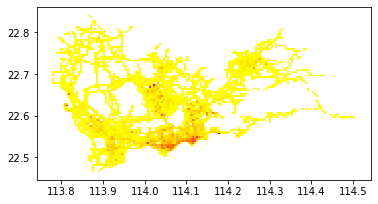

In [25]:
#聚合集计栅格内数据量
grid_agg = data.groupby(['LONCOL','LATCOL'])['VehicleNum'].count().reset_index()
#生成栅格的几何图形
grid_agg['geometry'] = tbd.grid_to_polygon([grid_agg['LONCOL'],grid_agg['LATCOL']],params)
#转换为GeoDataFrame
import geopandas as gpd
grid_agg = gpd.GeoDataFrame(grid_agg)
#绘制栅格
grid_agg.plot(column = 'VehicleNum',cmap = 'autumn_r')

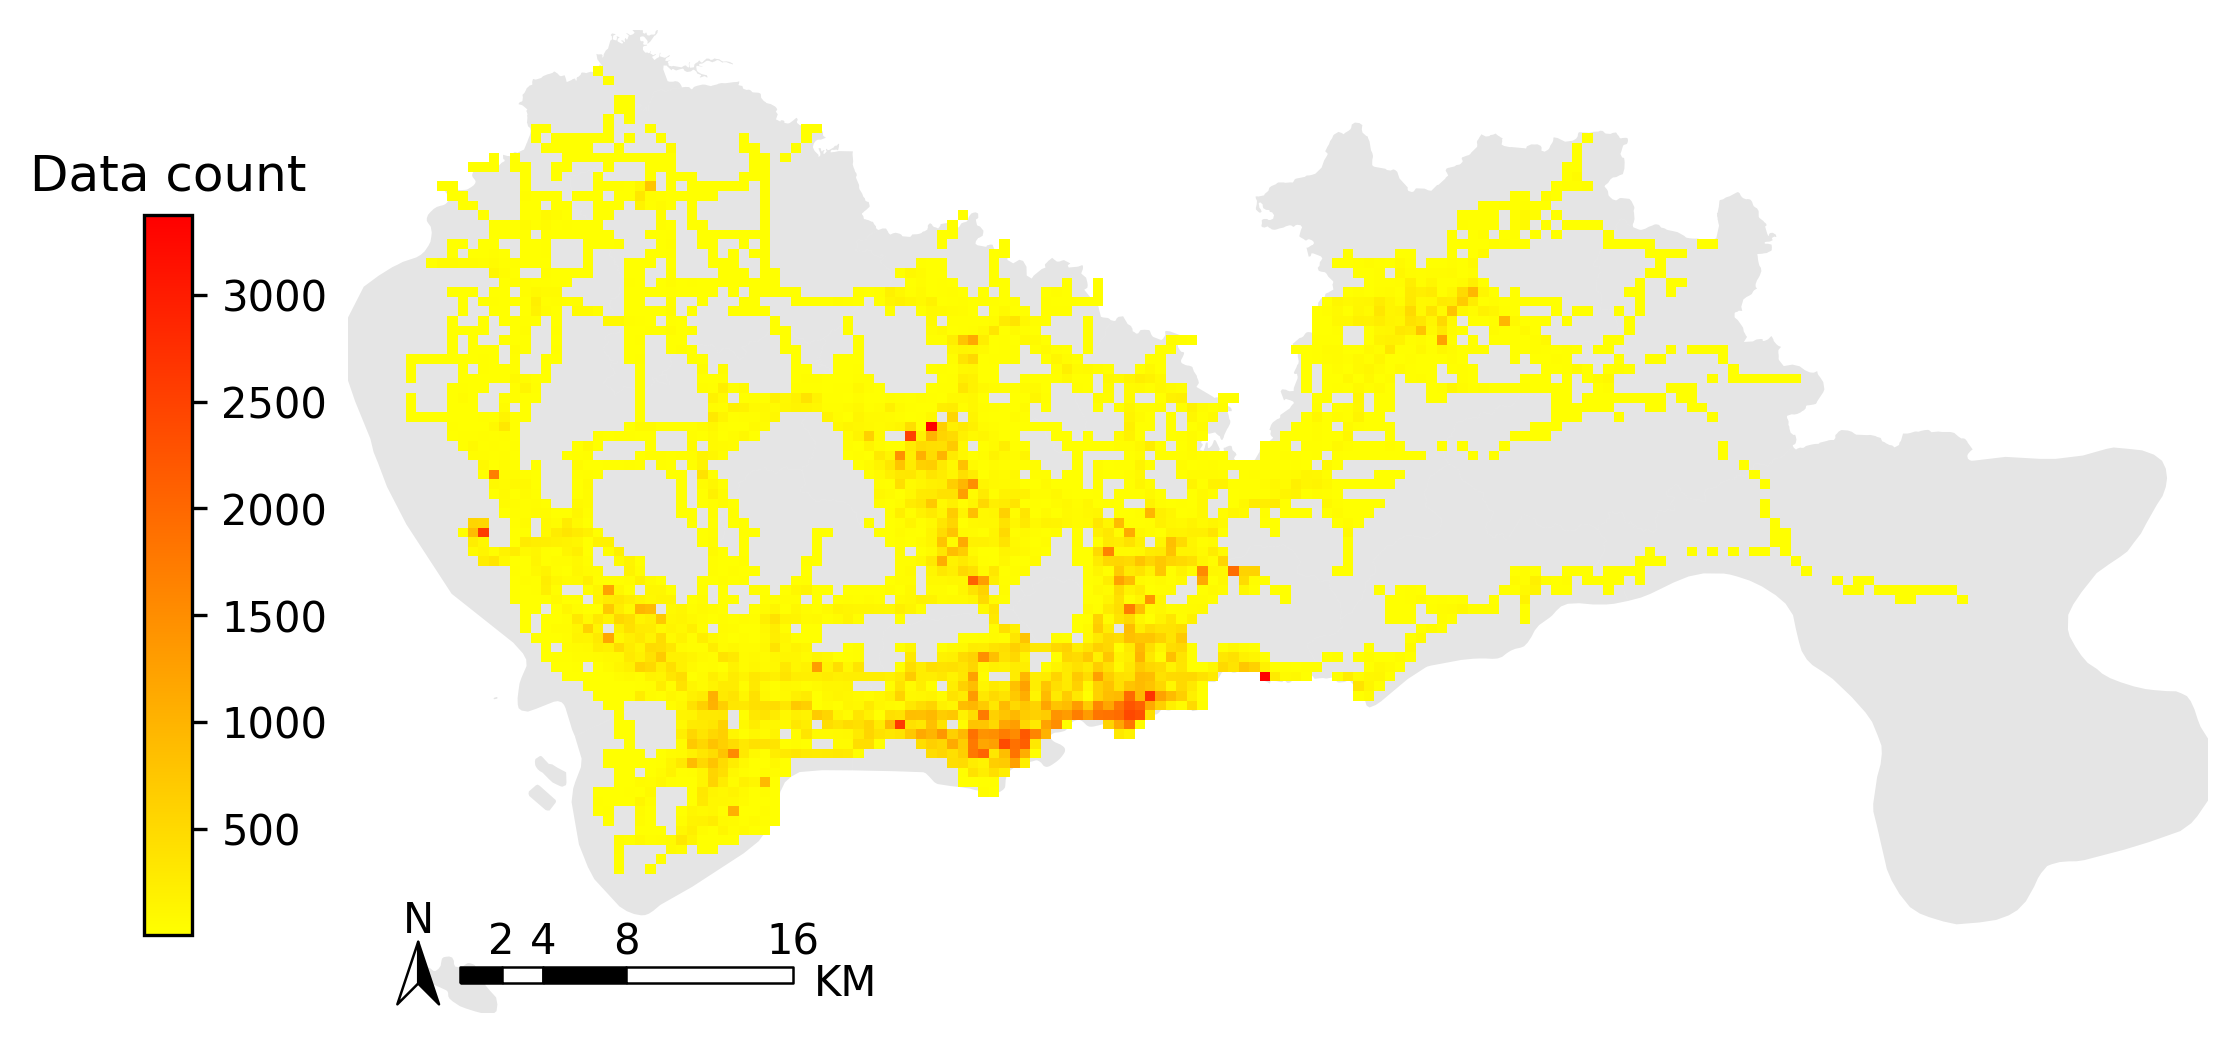

In [26]:
import matplotlib.pyplot as plt

fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#加载地图底图
#tbd.plot_map(plt,bounds,zoom = 11,style = 11)
#添加行政区划边界
sz.plot(ax = ax,edgecolor = (0,0,0,0),facecolor = (0,0,0,0.1),linewidths=0.5)
#定义色条位置
cax = plt.axes([0.04, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)
#绘制数据
grid_agg.plot(column = 'VehicleNum',cmap = 'autumn_r',ax = ax,cax = cax,legend = True)
#添加指北针和比例尺
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## 出租车出行OD提取与集计

使用tbd.taxigps_to_od方法，传入对应的列名，即可提取出行OD:

In [10]:
#从GPS数据提取OD
oddata = tbd.taxigps_to_od(data,col = ['VehicleNum','time','lon','lat','OpenStatus'])
oddata

,VehicleNum,stime,slon,slat,etime,elon,elat,ID
427075,22396,00:19:41,114.013016,22.664818,00:23:01,114.021400,22.663918,0
131301,22396,00:41:51,114.021767,22.640200,00:43:44,114.026070,22.640266,1
417417,22396,00:45:44,114.028099,22.645082,00:47:44,114.030380,22.650017,2
376160,22396,01:08:26,114.034897,22.616301,01:16:34,114.035614,22.646717,3
21768,22396,01:26:06,114.046021,22.641251,01:34:48,114.066048,22.636183,4
...,...,...,...,...,...,...,...,...
57666,36805,22:37:42,114.113403,22.534767,22:48:01,114.114365,22.550632,5332
175519,36805,22:49:12,114.114365,22.550632,22:50:40,114.115501,22.557983,5333
212092,36805,22:52:07,114.115402,22.558083,23:03:27,114.118484,22.547867,5334
119041,36805,23:03:45,114.118484,22.547867,23:20:09,114.133286,22.617750,5335


对提取出的OD进行OD的栅格集计,并生成GeoDataFrame

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

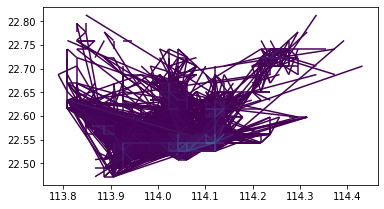

In [11]:
#获取栅格化参数
params = tbd.area_to_params(bounds,accuracy = 2000)
#栅格化OD并集计
od_gdf = tbd.odagg_grid(oddata,params)
od_gdf.plot(column = 'count')

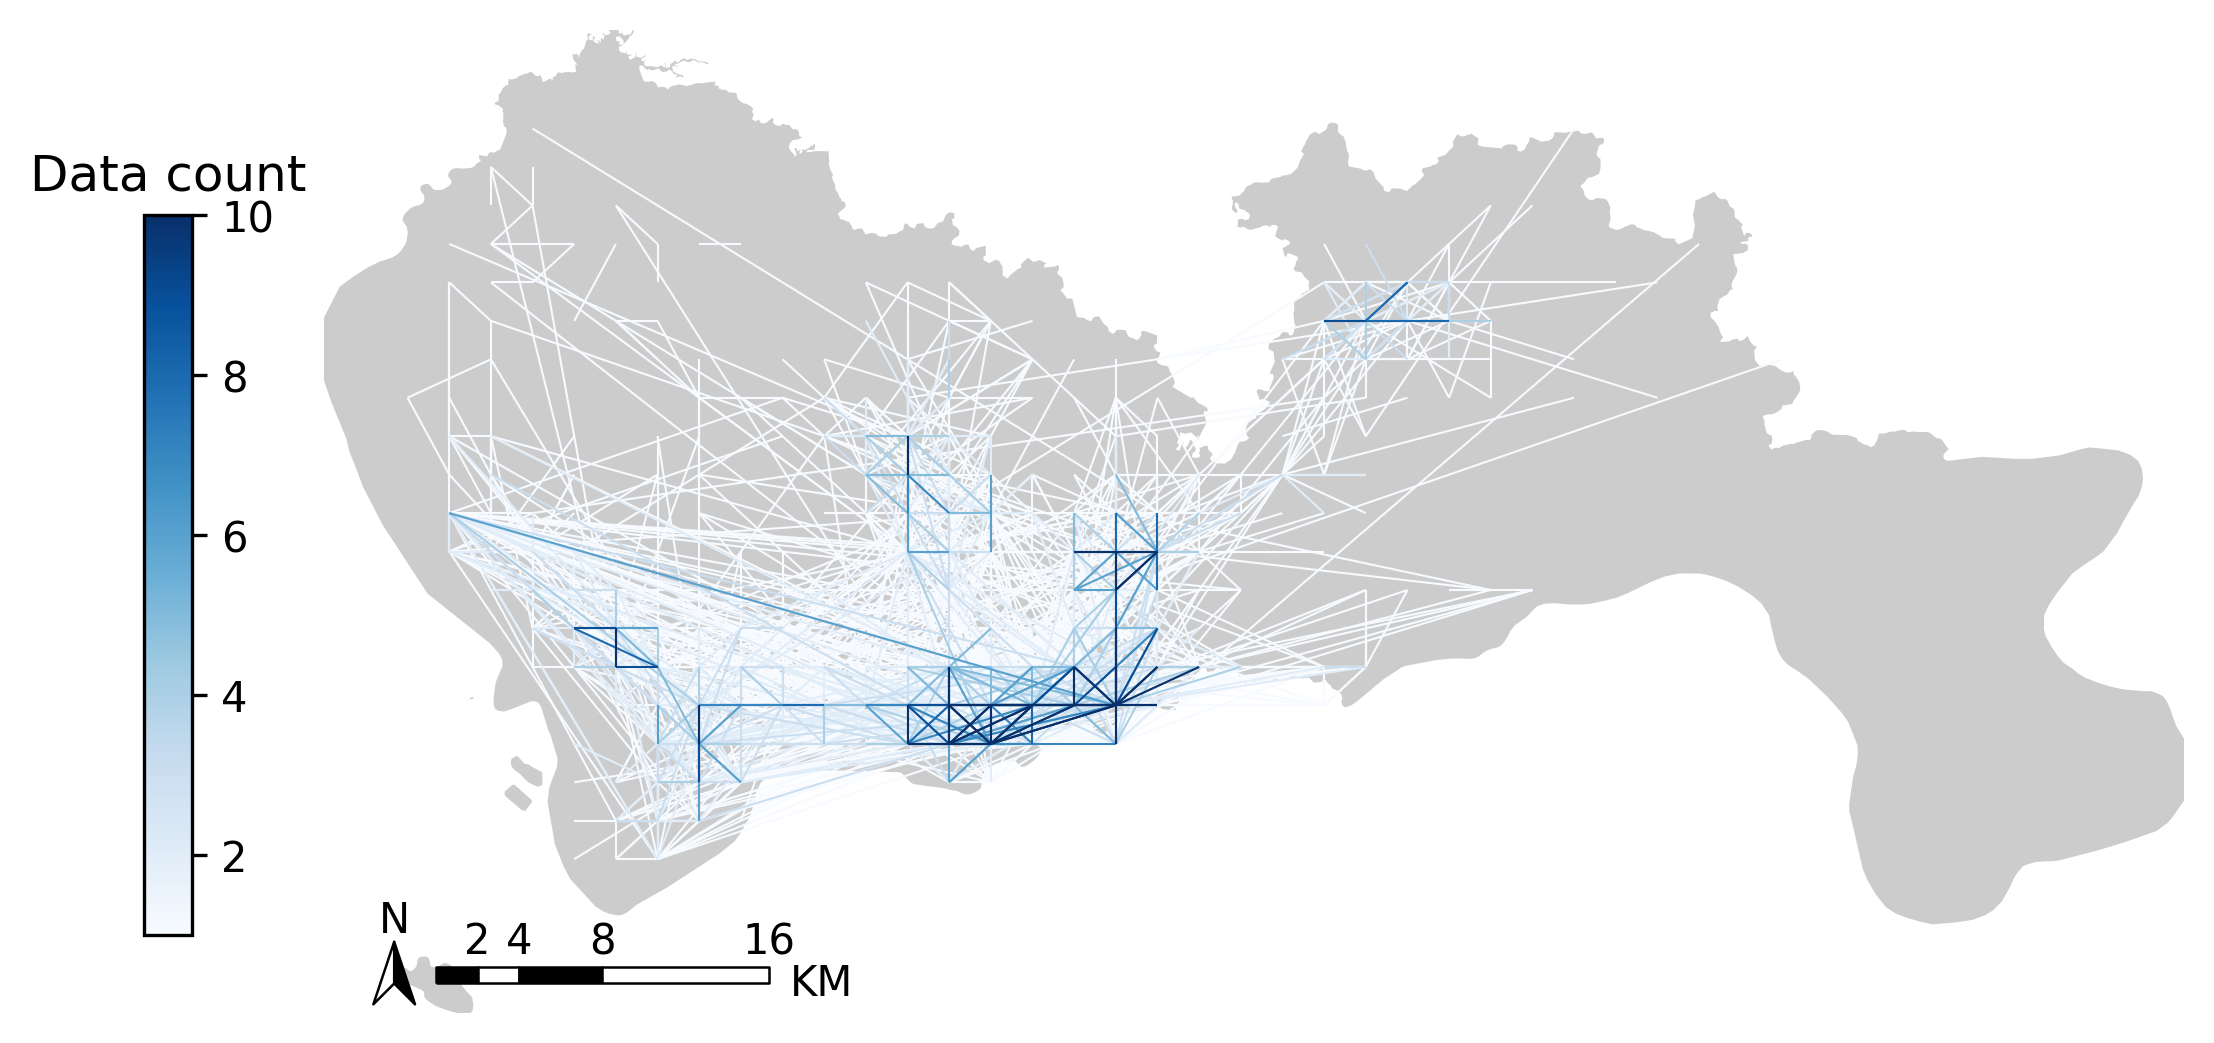

In [18]:
#创建图框
import matplotlib.pyplot as plt
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#添加地图底图
#tbd.plot_map(plt,bounds,zoom = 11,style = 11)
sz.plot(ax = ax,edgecolor = (0,0,0,0),facecolor = (0,0,0,0.2),linewidths=0.5)
#绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)
#绘制OD
od_gdf.plot(ax = ax,column = 'count',cmap = 'Blues',linewidth = 0.5,vmax = 10,cax = cax,legend = True)
#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## OD小区集计

TransBigData包也提供了将OD直接集计到小区的方法

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

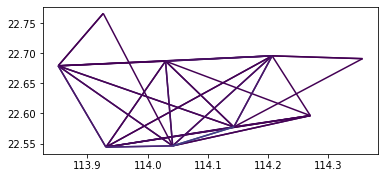

In [28]:
#OD集计到小区（在不传入栅格化参数时，直接用经纬度匹配）
od_gdf = tbd.odagg_shape(oddata,sz,round_accuracy=6)
od_gdf.plot(column = 'count')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

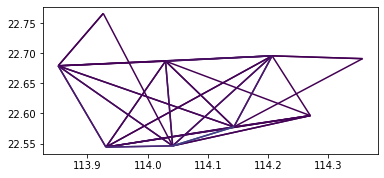

In [29]:
#OD集计到小区（传入栅格化参数时，先栅格化后匹配，可加快匹配速度，数据量大时建议使用）
od_gdf = tbd.odagg_shape(oddata,sz,params = params)
od_gdf.plot(column = 'count')

tbd中提供了地图底图加载和比例尺指北针的功能。使用plot_map方法添加地图底图，plotscale添加比例尺和指北针:

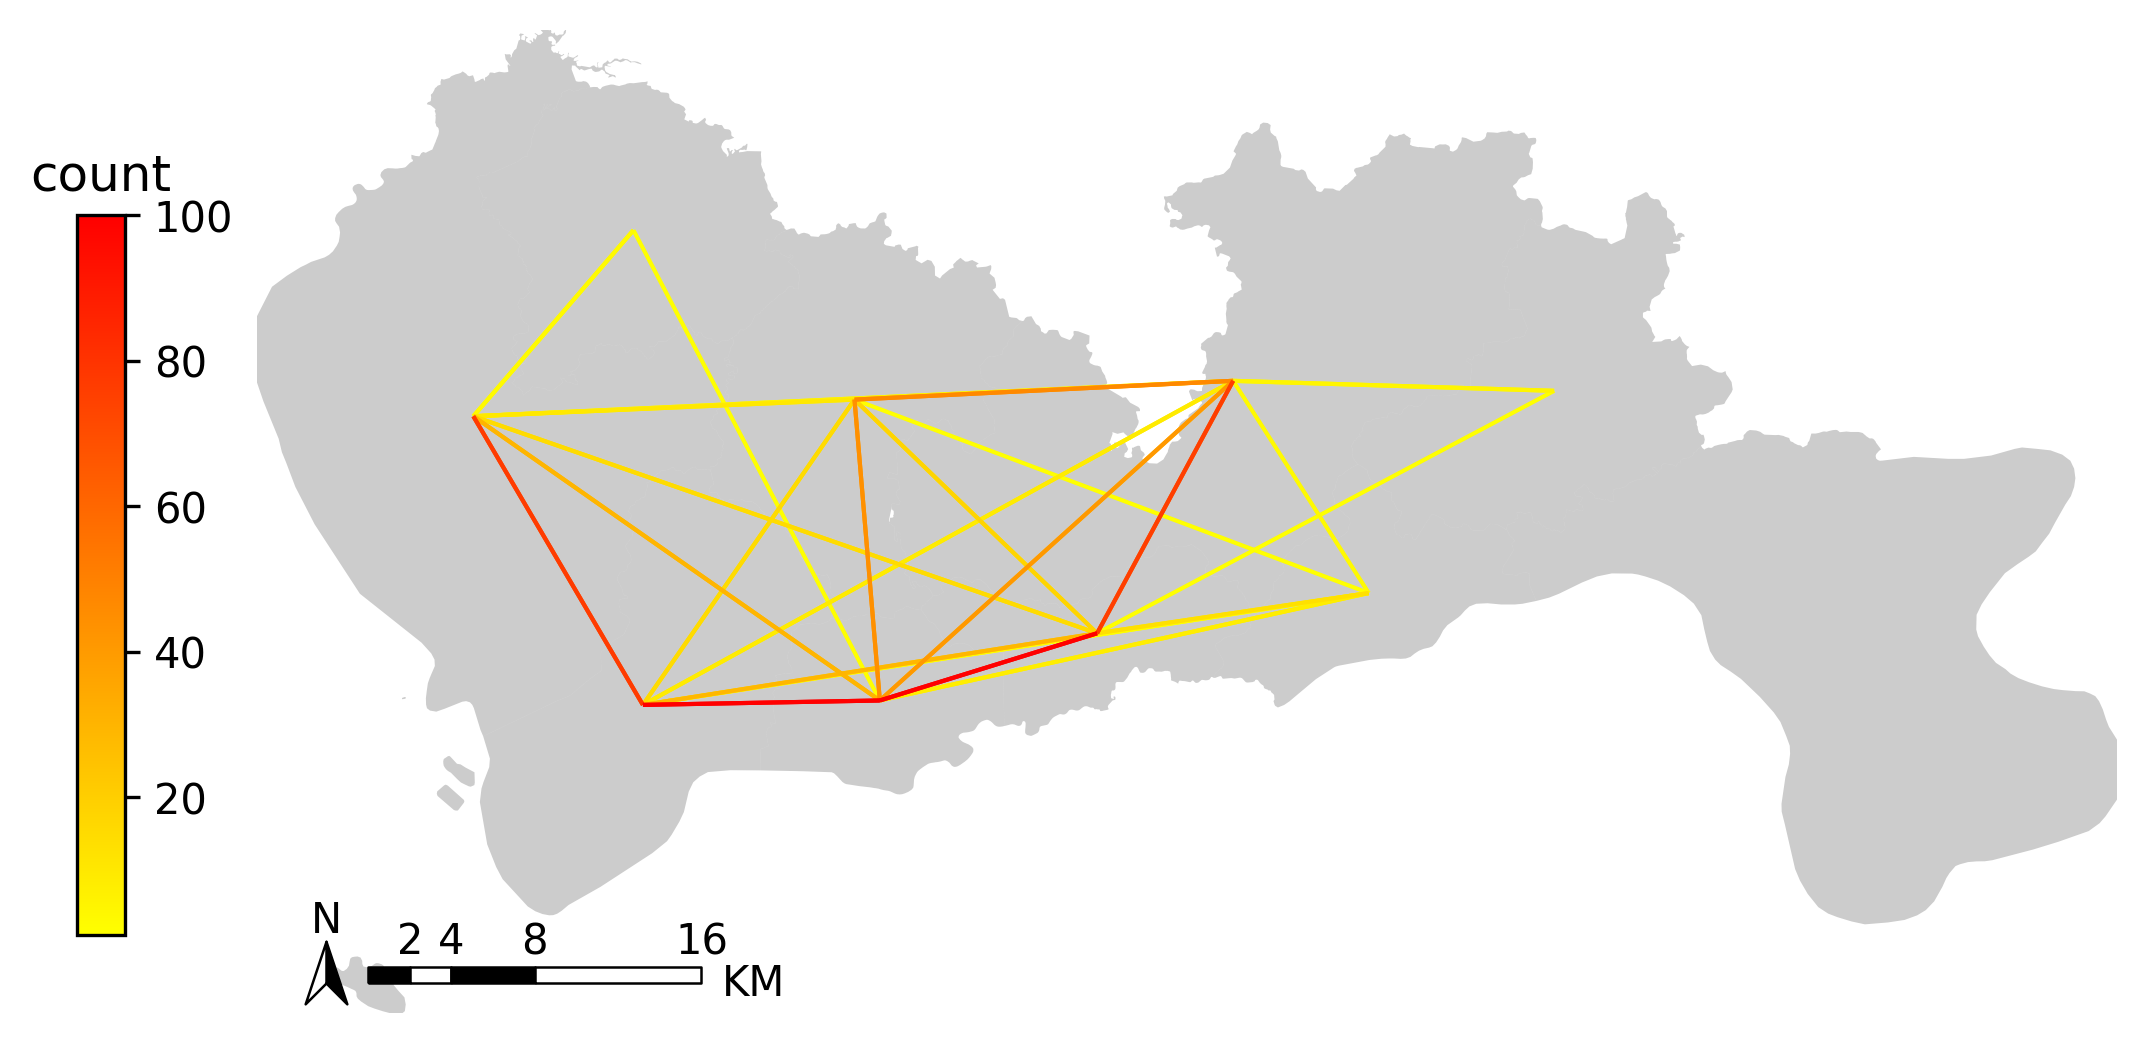

In [31]:
#创建图框
import matplotlib.pyplot as plt
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#添加地图底图
#tbd.plot_map(plt,bounds,zoom = 12,style = 4)
sz.plot(ax = ax,edgecolor = (0,0,0,0),facecolor = (0,0,0,0.2),linewidths=0.5)
#绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('count')
plt.sca(ax)
#绘制OD
od_gdf.plot(ax = ax,vmax = 100,column = 'count',cax = cax,cmap = 'autumn_r',linewidth = 1,legend = True)
#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

# 可视化

In [29]:
#可视化数据点分布
tbd.visualization_data(data,col = ['lon','lat'],accuracy=1000,height = 500)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ytak0zp', 'type': …

In [30]:
tbd.visualization_trip(data,col = ['lon','lat','VehicleNum','time'],height = 500)

Processing trajectory data...
Generate visualization...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hizm36i', 'type': …

In [31]:
tbd.visualization_od(oddata,accuracy=2000,height = 500)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'd3s4dcp', 'type': …